First move to the directory where the python files for image analysis are stored.

In [1]:
cd /home/kuhlmanlab/Documents/GitHub/microscopyimageprocessing/

/home/kuhlmanlab/Documents/GitHub/microscopyimageprocessing


Then import the necessary python libraries (including our custom collections of helper functions) and set up our matplotlib plotting options.

In [2]:
import copy
import matplotlib as mpl
mpl.rcParams["axes.grid"] = False
mpl.rcParams["image.cmap"] = "viridis"
mpl.rcParams["image.interpolation"]="nearest"
mpl.rcParams["image.origin"] = "lower"
import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipyd
import numpy as np
import skimage.morphology as skmo
import skimage.measure as skme
import skimage.io as skio
import skimage.transform as sktr

import visualization as mvis
import segmentation as mseg
import illuminationinterpolation as illint

# Aligning the DS-Fi2 camera to the DU-897 camera

First we need to load images of beads for aligning the camera and finding the transformations relating the coordinates between different types of images.

In [3]:
beads_name = "/home/kuhlmanlab/Documents/2nd round of pET28a-mRFP experiments/M63 glucose 2/10 iptg/TIFFS/beads/"
beads_pc = skio.ImageCollection(beads_name+"*c2*c1.tif")
beads_TIRF = skio.ImageCollection(beads_name+"*c1*c2.tif")
beads_BF = skio.ImageCollection(beads_name+"*c1*c1.tif")
zero_signal = skio.ImageCollection("/home/kuhlmanlab/Documents/1st round of pET28a-mRFP experiments/4 October 2016 pETK mRFP/*zero*100 ms*.tif")[0]

Then inspect the images to make sure they've loaded and they look good.

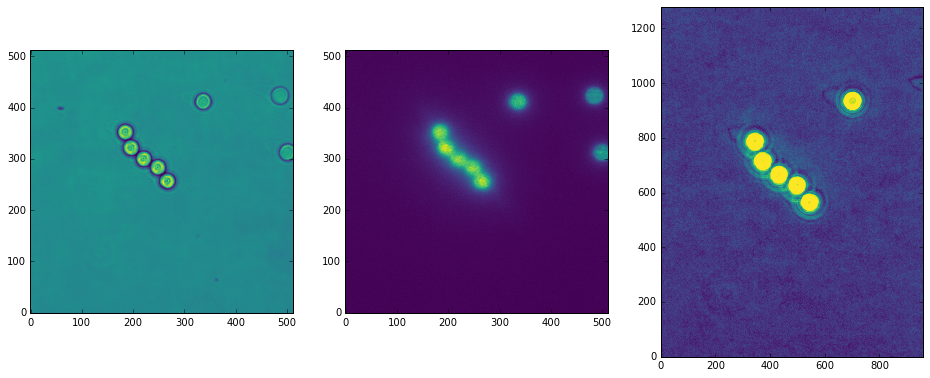

In [4]:
mvis.inspectImages([beads_BF, beads_TIRF, beads_pc], (16,10))

Then inspect the background illumination in the brightfield and phase contrast channels.

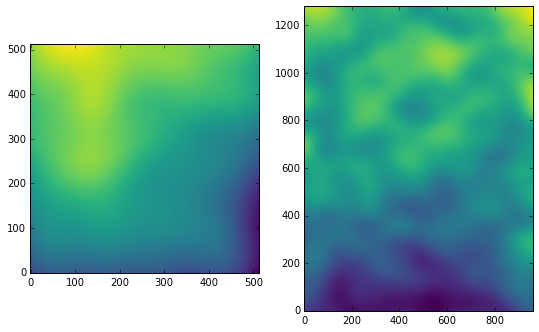

In [5]:
beads_BF_bg = mseg.findMedianBg(beads_BF)
beads_pc_bg = mseg.findMedianBg(beads_pc)
mvis.showImages((beads_BF_bg, beads_pc_bg),(9,6))

Then normalize all brightfield and phase contrast images by a dividing each images intensity by the background illumination (pixel by pixel).

In [6]:
beads_BF_n = [image / beads_BF_bg for image in beads_BF]
beads_pc_n = [image / beads_pc_bg for image in beads_pc]

Next before the phase contrast and TIRF images can be aligned, we need to find the beads. This function does it for brightfield, but a simple threshold will work for phase contrast or TIRF.

In [7]:
def findBeadsBF(image,thr):
    outline = image < thr
    clean = skmo.remove_small_objects(outline,min_size=100)
    filled = skmo.remove_small_holes(clean, min_size=10000)
    bead_mask = skmo.remove_small_objects(np.logical_xor(clean,filled),min_size=300)
    return bead_mask

The threshold for finding beads in brightfield can be found with the helper function below. There is variation from image to image but taking the median usually works well.

In [8]:
threshes = [mseg.localMinLeftOfGlobalMax(image) for image in beads_BF_n]
thr1 = np.median(np.array(threshes))

In [9]:
bead_BF_masks = [findBeadsBF(image,thr1) for image in beads_BF_n]

/home/kuhlmanlab/anaconda3/lib/python3.5/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


Once we have masks for the beads, inspect the masks to make sure they don't pick up background as beads. It's ok if a few beads are missed.

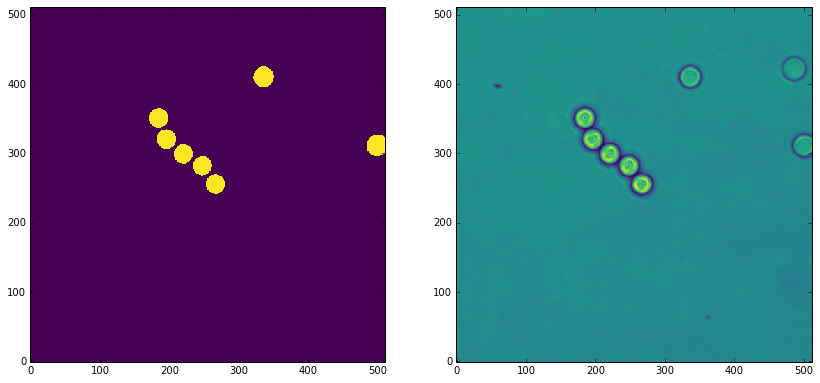

In [10]:
mvis.inspectImages([bead_BF_masks,beads_BF],(14,7))

The phase contrast channel is a lot easier to find the masks for. A high threshold usually works. Inspect these masks next to the brightfield masks. We'll need a good field of view for alignment.

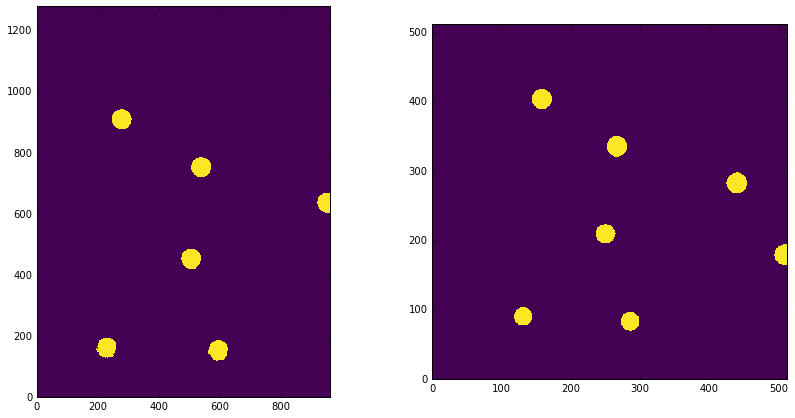

In [11]:
bead_pc_masks = [image>240 for image in beads_pc_n]
bpcm = [skmo.remove_small_holes(mask,min_size=1000) for mask in bead_pc_masks]
bpcm = [skmo.remove_small_objects(mask, min_size=1000) for mask in bpcm]
mvis.inspectImages([bpcm, bead_BF_masks],(14,7))

Once you've picked a field of view, the findRegionCenters helper function will find the centers of the beads in a mask.

In [12]:
index2=10
BF2pc_align_mask = bead_BF_masks[index2]
PC_align_mask = bpcm[index2]
BF2pc_centers = mseg.findRegionCenters(BF2pc_align_mask)
PC_centers = mseg.findRegionCenters(PC_align_mask)

/home/kuhlmanlab/anaconda3/lib/python3.5/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


You'll need to loop through the next two cells until the lines drawn between the two images are matching beads up correctly. The first cell is used to add, removem and rearrange the order of bead centers from the lists of centers to be matched between cameras.

In [13]:
BF2pc_centers_cl = BF2pc_centers[[0,1,2,4,5]]
PC_centers_cl = PC_centers[[0,1,2,4,5]]

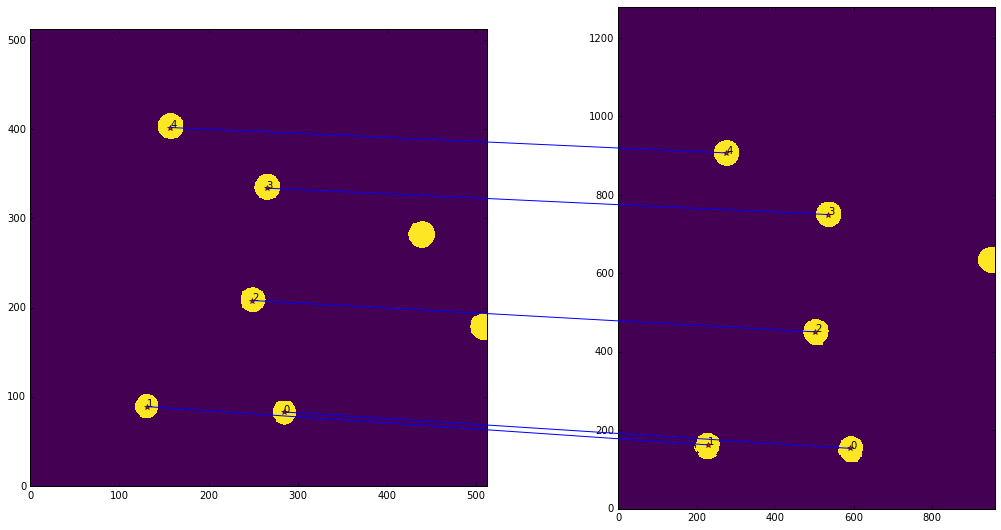

In [14]:
mvis.showKeypointpairs(BF2pc_align_mask, PC_align_mask, BF2pc_centers_cl, PC_centers_cl)

Once the beads are paired up well, skimage can easily find the geometric transform between them.

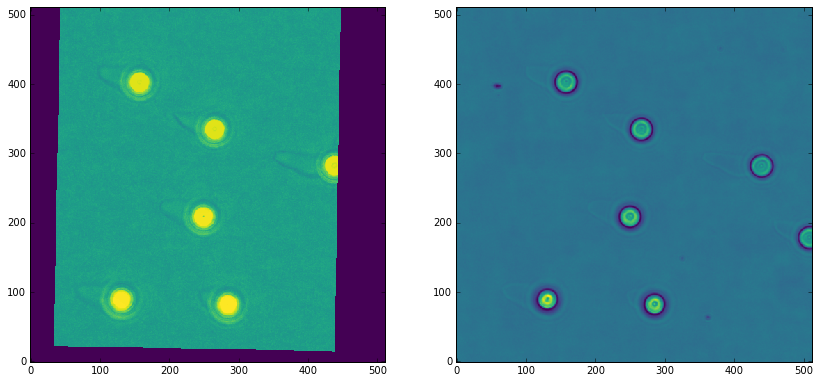

In [15]:
camera_transform_p = sktr.SimilarityTransform()
camera_transform_p.estimate(BF2pc_centers_cl,PC_centers_cl)
beads_PC_warped = mseg.warpIm2Im(beads_pc_n[index2],beads_BF_n[index2],camera_transform_p)
mvis.showImages([beads_PC_warped, beads_BF_n[index2]],(14,7))

It's good to print out the transform because we may need to adjust it by hand later down. We also make a copy of it so we don't adjust the original transform skimage found

In [16]:
total_transform = sktr.SimilarityTransform()
total_transform.params = copy.deepcopy(camera_transform_p.params)
print(total_transform.params)

[[  2.37495501e+00   4.38471092e-02  -5.46135498e+01]
 [ -4.38471092e-02   2.37495501e+00  -7.94535529e+01]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]


# Finding the illumination field
Now that we've found the alignment between the different types of images; the beads can be used as a reference to find the illumination field which can correct intensities for the unevenness of the TIRF illumination field.

First we find masks for each bead. We can use brightfield masks for this or warp the phase contrast masks into brightfield coordinates. Using the phase contrast masks will lose some information on the illumination field but we only consider e. coli we see in phase contrast anyways so that lost information is irrelevant. Making masks from the TIRF directly is difficult and error prone.

In [17]:
beads_label = [skme.label(mask) for mask in bead_BF_masks]
beads_rprops_raw = [skme.regionprops(label, TIRF) for label, TIRF in zip(beads_label, beads_TIRF)]
beads_plist = mseg.properties2list(beads_rprops_raw,['mean_intensity','area','centroid'])

In [18]:
print('There are', len(beads_plist['mean_intensity']), 'beads.')
print('The mean intensity of the beads is', '%.0f' % np.mean(beads_plist['mean_intensity']), '.')
print('The standard deviation of intensity of the beads is', 
      '%.0f' % np.std(beads_plist['mean_intensity']), '.')
print('The mean area of the beads is', '%.0f' % np.mean(beads_plist['area']), '.')
print('The standard deviation of area of the beads is', '%.0f' % np.std(beads_plist['area']), '.')

There are 97 beads.
The mean intensity of the beads is 16596 .
The standard deviation of intensity of the beads is 6034 .
The mean area of the beads is 608 .
The standard deviation of area of the beads is 71 .


We estimate the TIRF illumination by an average of the brightness of the beads weighted by distance from the point being considered.

In [19]:
bead_gauss_dfunc = illint.createGaussianDistFunc(beads_plist['centroid'],
                                                 beads_plist['mean_intensity'] - np.mean(zero_signal),80)
bead_TIRF_bg_gaus = illint.evaluateDistsBox(512,512,bead_gauss_dfunc)
bead_TIRF_bg_gaus = bead_TIRF_bg_gaus / np.mean(bead_TIRF_bg_gaus)

It's always good to look at the estimated TIRF illumination. It shouldn't look too blocky.

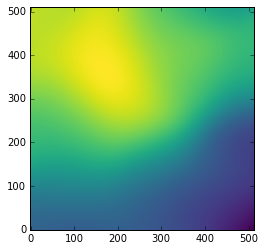

In [20]:
plt.imshow(bead_TIRF_bg_gaus)

It's also good to print out the minimum and maximum relative intensities in illumination. Make sure they are both positive and not too low!

In [21]:
bg_max = np.max(bead_TIRF_bg_gaus)
bg_min = np.min(bead_TIRF_bg_gaus)
print('The brightest relative intensity is', '%.2f' % bg_max, '.')
print('The dimmest relative intensity is', '%.2f' % bg_min, '.')
print('This is a factor of', '%.2f' % (bg_max/bg_min), 'between the brightest and dimmest areas.')

The brightest relative intensity is 1.45 .
The dimmest relative intensity is 0.27 .
This is a factor of 5.30 between the brightest and dimmest areas.


Then normalize the TIRF images by subtracting the zero signal and dividing by the illumination.

In [22]:
beads_TIRF_n = [np.clip((image - np.mean(zero_signal)),0,np.inf)/bead_TIRF_bg_gaus for image in beads_TIRF]

In [23]:
beads_rprops_n = [skme.regionprops(label, TIRF) for label, TIRF in zip(beads_label, beads_TIRF_n)]
beads_plist_n = mseg.properties2list(beads_rprops_n,['mean_intensity','area','centroid'])

The beads intensities should be unimodal.

(array([  1.,   1.,   2.,  10.,  15.,  34.,  16.,  13.,   5.]),
 array([  4699.76971834,   6634.83226047,   8569.8948026 ,  10504.95734474,
         12440.01988687,  14375.082429  ,  16310.14497113,  18245.20751326,
         20180.27005539,  22115.33259752]),
 <a list of 9 Patch objects>)

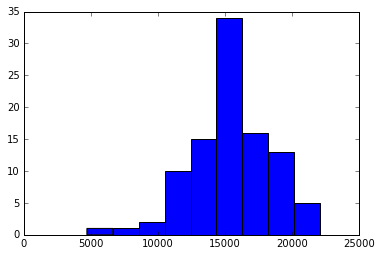

In [24]:
n_beads = len(beads_plist_n['mean_intensity'])
plt.hist(beads_plist_n['mean_intensity'],bins=np.sqrt(n_beads).astype('int32'))

In [25]:
bead_mean_n = np.mean(beads_plist_n['mean_intensity'])
bead_stderr_n = np.std(beads_plist_n['mean_intensity'])/np.sqrt(n_beads)
print('After illumination correction, the mean intensity of the beads is',
      '%.0f' % bead_mean_n,'+-', '%.0f' % bead_stderr_n)

After illumination correction, the mean intensity of the beads is 15520 +- 287


# Identifying the *e. coli* in phase contrast
First we import all the images of *e. coli* and use the phase contrast images to separate the cells from the background. We also use the illumination field gained from the beads to correct the illumination in the e. coli TIRF images.

In [26]:
cell_name = "/home/kuhlmanlab/Documents/2nd round of pET28a-mRFP experiments/M63 glucose 2/10 iptg/TIFFS/cells/"
ecoli_TIRF = skio.ImageCollection(cell_name+"*c1*c2.tif")
ecoli_pc = skio.ImageCollection(cell_name+"*c2*c1.tif")
ecoli_BF = skio.ImageCollection(cell_name+"*c1*c1.tif")

Always inspect imported images.

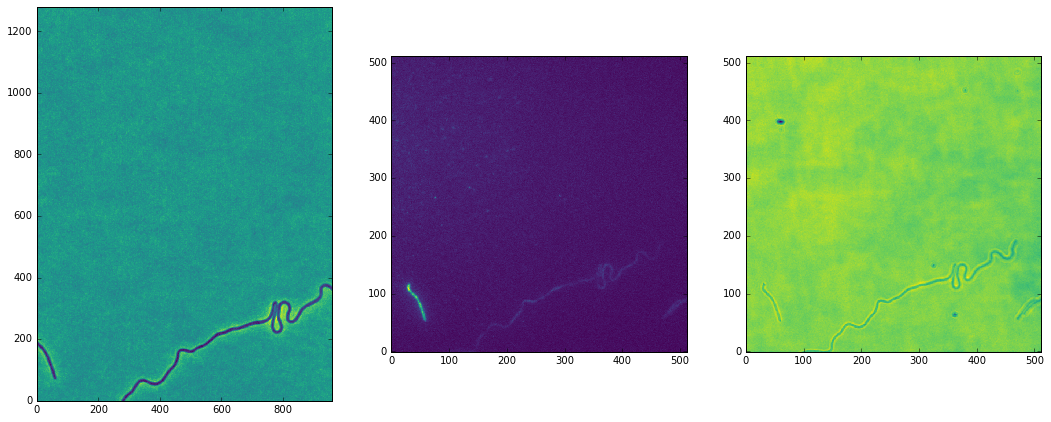

In [27]:
mvis.inspectImages([ecoli_pc,ecoli_TIRF,ecoli_BF],(18,8))

This next function does the illumination correction for the e. coli phase contrast images and also nonlocal means denoising (using opencv library) on the phase contrast. This denoising is important to getting a good result from thresholding to find the e. coli. The denoising will generally give a warning about loss of precision upon converting float64 to uint8. Do not worry about this, phase contrast intensities are not used for quantification so it doesn't matter.

In [28]:
ecoli_pc_norm = mseg.normAndDenoisePc(ecoli_pc)

/home/kuhlmanlab/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


The TIRF images are normalized by subtracting the zero signal and dividing by the illumination field found from the beads.

In [29]:
ecoli_TIRF_norm = [np.clip((image - np.mean(zero_signal)),0,np.inf) / bead_TIRF_bg_gaus for image in ecoli_TIRF]

Once we've normalized the images, it's time to threshold the phase contrast images. The automated thresholding followed by cleaning up any objects too small to be e. coli works pretty well, but goes wonky occasinally so we'll have to manually drop any images with bad segmentation.

In [30]:
b_masks_cl = [mseg.thresholdMask(image,min_size=300) for image in ecoli_pc_norm]

/home/kuhlmanlab/anaconda3/lib/python3.5/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


Of course, we inspect the masks as we inspect everything else. The index on the slider of masks that look bad should go into the indices to blank functin of the cell after.

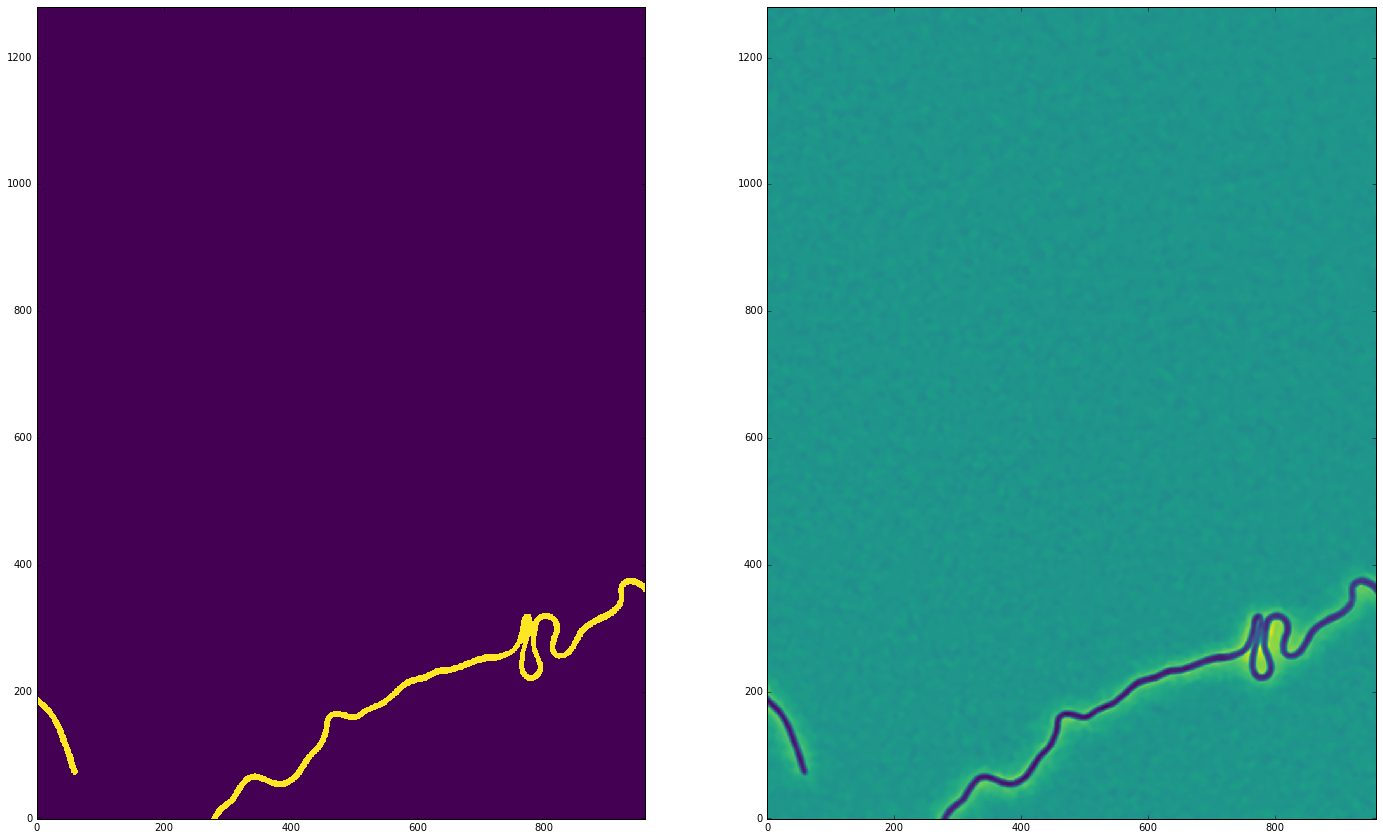

In [31]:
mvis.inspectImages([b_masks_cl,ecoli_pc_norm],(24,16))


Then we drop any images with bad segmentation. You can only drop badly missegmented images or be extremely aggressive (as in this example) in dropping any images with even suspected missegmentations as long as you're consistent about it.

In [32]:
indices_to_blank = [16,30,51,63,123,138,151,153,165,182,188,192,194]
for index in indices_to_blank:
    b_masks_cl[index] = np.zeros_like(b_masks_cl[index])

# Inspecting aligment and making small corrections to misalignment.

Next I use the masks for *e. coli* from phase contrast and transform them to align to the TIRF and see how well they line up. I then tweak the parameters of the transformation by hand using the sliders until the alignment is satisfactory to my eyes.

In [33]:
camera_transform_ec = copy.deepcopy(total_transform)
tabwidget = mvis.adjustAlignment(ecoli_TIRF,b_masks_cl,camera_transform_ec)
ipyd.display(tabwidget)

The transform looks good.

In [34]:
camera_transform_ec.params

array([[  2.37495501e+00,   4.38471092e-02,  -5.46135498e+01],
       [ -4.38471092e-02,   2.37495501e+00,  -7.94535529e+01],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

Next we make labeled arrays from the phase contrast masks and then only after labeling, warp them into the TIRF coordinates (otherwise we accidentally might fuse separated cells since there are more pixels per area in phase contrast than in TIRF).

In [35]:
ec_labels = [skme.label(mask) for mask in b_masks_cl]
ec_labels_w = [mseg.warpIm2Im(label,ecoli_TIRF[0],camera_transform_ec) for label in ec_labels]

# Determining the mean signal (brightness per pixel in a cell)

Now the only thing that remains is to use the warped phase contrast masks and normalized TIRF images to find the distribution of e. coli intensities.

(array([ 226.,  213.,   99.,   42.,   20.,    9.,    2.,    2.,    0.,
           1.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    1.]),
 array([   489.09964211,   2183.10934405,   3877.11904598,   5571.12874791,
          7265.13844984,   8959.14815177,  10653.1578537 ,  12347.16755563,
         14041.17725756,  15735.18695949,  17429.19666142,  19123.20636335,
         20817.21606528,  22511.22576721,  24205.23546914,  25899.24517107,
         27593.25487301,  29287.26457494,  30981.27427687,  32675.2839788 ,
         34369.29368073,  36063.30338266,  37757.31308459,  39451.32278652,
         41145.33248845]),
 <a list of 24 Patch objects>)

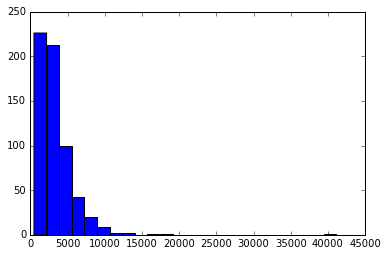

In [36]:
ec_rprops = [skme.regionprops(label,TIRF) for label, TIRF in zip(ec_labels_w, ecoli_TIRF_norm)]
ec_intensities = mseg.properties2list(ec_rprops, ['mean_intensity'])['mean_intensity']
n_ec = len(ec_intensities)
plt.figure()
urg = plt.subplot(111)
urg.hist(ec_intensities,bins=np.sqrt(n_ec).astype('int32'))

In [37]:
ec_meanintensity = np.mean(ec_intensities)
ec_stderrintensity = np.std(ec_intensities)/np.sqrt(n_ec)
print('The mean intensity of the e. coli is', '%.0f' % ec_meanintensity,'+-', '%.0f' % ec_stderrintensity)

The mean intensity of the e. coli is 3341 +- 107


### Comparing the signal to an objective standard
To make the signal meaningful for comparison, we have to compare it to the brightness of the beads on the same slide.

In [38]:
ec_intensities_n = ec_intensities / bead_mean_n

(array([ 226.,  213.,   99.,   42.,   20.,    9.,    2.,    2.,    0.,
           1.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    1.]),
 array([ 0.03151413,  0.14066418,  0.24981423,  0.35896428,  0.46811433,
         0.57726437,  0.68641442,  0.79556447,  0.90471452,  1.01386457,
         1.12301461,  1.23216466,  1.34131471,  1.45046476,  1.5596148 ,
         1.66876485,  1.7779149 ,  1.88706495,  1.996215  ,  2.10536504,
         2.21451509,  2.32366514,  2.43281519,  2.54196524,  2.65111528]),
 <a list of 24 Patch objects>)

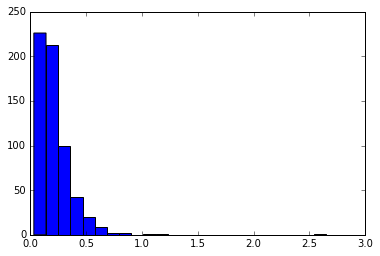

In [39]:
plt.hist(ec_intensities_n,bins=np.sqrt(n_ec).astype('int32'))

In [40]:
ec_meanintensity_n = ec_meanintensity / bead_mean_n
ec_meanintensity_n_lefterr = (ec_meanintensity)/(bead_mean_n + bead_stderr_n)
ec_meanintensity_n_righterr = (ec_meanintensity)/(bead_mean_n - bead_stderr_n)
print(ec_meanintensity_n_lefterr,' ',ec_meanintensity_n,' ',ec_meanintensity_n_righterr)

0.21132562754   0.215239908599   0.219301930815


In [41]:
ec_stdintensity_n = np.std(ec_intensities_n)
print(ec_stdintensity_n/ec_meanintensity_n)

0.797276222226
